In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import matplotlib as mpl
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path_S1 = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/cph central and nørreport measurements/Station 1/'
path_S2 = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/cph central and nørreport measurements/Station 2/'

NS1 = read_SMPS(path_S1, parent_path, [-1, 0])
OPS1 = read_OPS(path_S1+'OPS/', parent_path, -1)
NS2 = read_SMPS(path_S2, parent_path, [-1, 0])
OPS2 = read_OPS(path_S2+'OPS/', parent_path, -1)

NS_dict_keys = ['2024-12-09_NanoScan', '2024-12-10_NanoScan', '2024-12-11_NanoScan', '2024-12-12_NanoScan', 
                '2024-12-13_NanoScan', '2024-12-16_NanoScan', '2024-12-17_NanoScan']
NS_bins = NS1['2024-12-06_NanoScan'].keys()[3:16].to_list()

OPS1_dict_keys = ['OPS1-CPH-d1', 'OPS1-CPH-d2', 'OPS1-CPH-d3', 'OPS1-CPH-d4', 'OPS1-CPH-d5', 'OPS1-NP-d1', 'OPS1-NP-d2'] # 'OPS1-CPH-n3', 'OPS1-CPH-n4'
OPS2_dict_keys = ['OPS2-CPH-d1', 'OPS2-CPH-d2', 'OPS2-CPH-d3', 'OPS2-CPH-d4', 'OPS2-CPH-d5', 'OPS2-NP-d1', 'OPS2-NP-d2']
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]
OPS_keys = OPS1['OPS1-HEPA'].keys()[1:17].to_list()

OPS1['OPS1-CPH-d5'] = pd.concat([OPS1['OPS1-CPH-d5-1'], OPS1['OPS1-CPH-d5-2']], ignore_index=True)
OPS1['OPS1-NP-d2'] = pd.concat([OPS1['OPS1-NP-d2-1'], OPS1['OPS1-NP-d2-2']], ignore_index=True)
OPS2['OPS2-CPH-d3'] = pd.concat([OPS2['OPS2-CPH-d3-1'], OPS2['OPS2-CPH-d3-2']], ignore_index=True)
OPS2['OPS2-CPH-d3'] = pd.concat([OPS2['OPS2-CPH-d3'], OPS2['OPS2-CPH-d3-3']], ignore_index=True)

NS1_bg_mean, NS1_bg_std, NS1_bg_error = bin_mean(['2024-12-06 11:05:00', '2024-12-06 11:45:00'], 
                                              NS1['2024-12-06_NanoScan'], NS_bins, 'Time', 0.1)
for key in NS_dict_keys:
    df = NS1[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS1_bg_mean[i]
    NS1[key] = df

NS2_bg_mean, NS2_bg_std, NS2_bg_error = bin_mean(['2024-12-06 11:05:00', '2024-12-06 11:45:00'], 
                                              NS2['2024-12-06_NanoScan'], NS_bins, 'Time', 0.1)
for key in NS_dict_keys:
    df = NS2[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS2_bg_mean[i]
    NS2[key] = df

OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]

OPS1_mass = {}
for key in OPS1_dict_keys:
    mass_conc = calc_mass_conc(OPS1[key], OPS_keys, OPS_mid_point, 1.2)
    OPS1_mass[key] = mass_conc

OPS2_mass = {}
for key in OPS2_dict_keys:
    mass_conc = calc_mass_conc(OPS2[key], OPS_keys, OPS_mid_point, 1.2)
    OPS2_mass[key] = mass_conc

NS_bin_mean = []
for key in NS_bins:
    NS_bin_mean.append(float(key) / 1000)
NS_cut_point = bin_edges(0.010, NS_bin_mean)

NS1_mass = {}
NS2_mass = {}
for key in NS_dict_keys:
    mass_conc1 = calc_mass_conc(NS1[key], NS_bins, NS_bin_mean, 1.2)
    NS1_mass[key] = mass_conc1
    mass_conc2 = calc_mass_conc(NS2[key], NS_bins, NS_bin_mean, 1.2)
    NS2_mass[key] = mass_conc2

In [3]:
timestamps = [['2024-12-09 12:00:00', '2024-12-09 16:30:00'],
              ['2024-12-10 09:15:00', '2024-12-10 16:00:00'],
              ['2024-12-11 09:00:00', '2024-12-11 16:00:00'],
              ['2024-12-12 09:00:00', '2024-12-12 16:00:00'],
              ['2024-12-13 08:45:00', '2024-12-13 14:00:00'],
              ['2024-12-16 09:45:00', '2024-12-16 15:45:00'],
              ['2024-12-17 09:15:00', '2024-12-17 15:45:00']]

ax_labels = ['Particle diameter / $\mu$m', 'dN/dlogDp, cm$^{-3}$', 'dM/dlogDp, $\mu$g/m$^{3}$']

In [4]:
OPS1_running = {}
OPS2_running = {}
for i, key in enumerate(OPS1_dict_keys):
    key_s2 = OPS2_dict_keys[i]
    number1 = running_mean(OPS1[key], None, OPS_keys, 'Time', '30T', 30, timestamps[i])
    OPS1_running[key + ' number'] = number1.T
    mass1 = running_mean(OPS1_mass[key], None, OPS_keys, 'Time', '30T', 30, timestamps[i])
    OPS1_running[key + ' mass'] = mass1.T
    number2 = running_mean(OPS2[key_s2], None, OPS_keys, 'Time', '30T', 30, timestamps[i])
    OPS2_running[key_s2 + ' number'] = number2.T
    mass2 = running_mean(OPS2_mass[key_s2], None, OPS_keys, 'Time', '30T', 30, timestamps[i])
    OPS2_running[key_s2 + ' mass'] = mass2.T

NS1_running = {}
NS2_running = {}
for i, key in enumerate(NS_dict_keys):
    number1 = running_mean(NS1[key], None, NS_bins, 'Time', '30T', 30, timestamps[i])
    NS1_running[key + ' number'] = number1.T
    mass1 = running_mean(NS1_mass[key], None, NS_bins, 'Time', '30T', 30, timestamps[i])
    NS1_running[key + ' mass'] = mass1.T
    number2 = running_mean(NS2[key], None, NS_bins, 'Time', '30T', 30, timestamps[i])
    NS2_running[key + ' number'] = number2.T
    mass2 = running_mean(NS2_mass[key], None, NS_bins, 'Time', '30T', 30, timestamps[i])
    NS2_running[key + ' mass'] = mass2.T


In [15]:
def plot_running_mean(fig, ax, df, bins, bin_edges, axis_labels, run_length, background):
    n_lines = len(df.keys())
    cmap = mpl.colormaps['plasma_r']
    colors = cmap(np.linspace(0, 1, n_lines))

    data = np.array(df[df.keys()]).T

    if bin_edges is not None:
        dlogDp = np.log10(bin_edges[1:]) - np.log10(bin_edges[:-1])
        data = data / dlogDp

    if background:
        for i in range(len(df.keys()[1:])):
            ax.plot(bins, data[i+1], color = colors[i+1], lw = 1.2)

        ax2 = ax.twinx()
        ax2.plot(bins, data[0], color = 'k', alpha = 0.3, label = 'Background', lw = 1)

        ax2.tick_params(axis = 'y', labelsize = 8, labelcolor = 'dimgrey')
        ax2.set_ylabel('Background ' + axis_labels[1], color = 'dimgrey')
    else:
        for i in range(n_lines):
            ax.plot(bins, data[i], color=colors[i], lw=1.2)

    # Create a scalar mappable for colorbar
    norm = mpl.colors.Normalize(vmin=run_length, vmax=run_length + (n_lines - 1) * run_length)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for colorbar

    # Add colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Time (min)', fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    ax.tick_params(axis='both', labelsize=8)
    ax.set(xlabel=axis_labels[0], ylabel=axis_labels[1], xscale='log')

C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\2152033723.py:16: UserWarning: The figure layout has changed to tight
  fig1.tight_layout()
C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\2152033723.py:26: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()
C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\2152033723.py:36: UserWarning: The figure layout has changed to tight
  fig3.tight_layout()


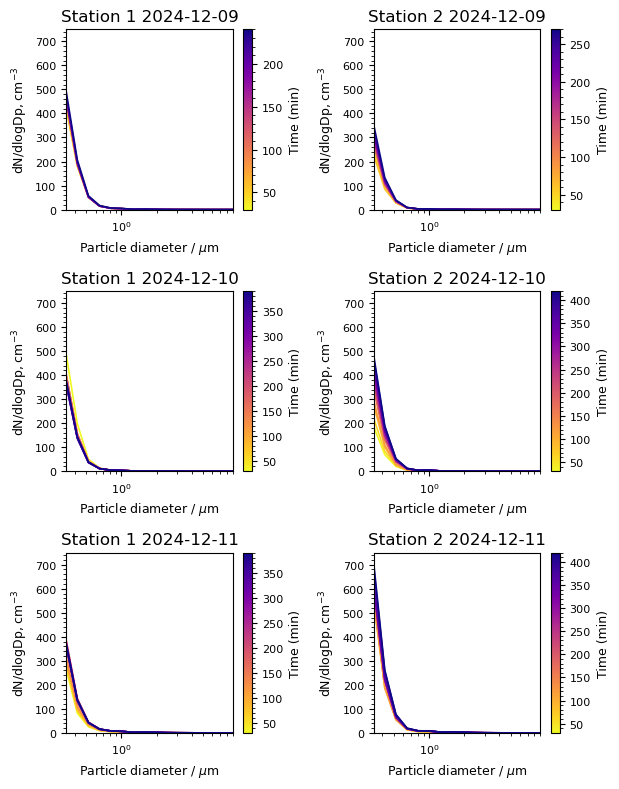

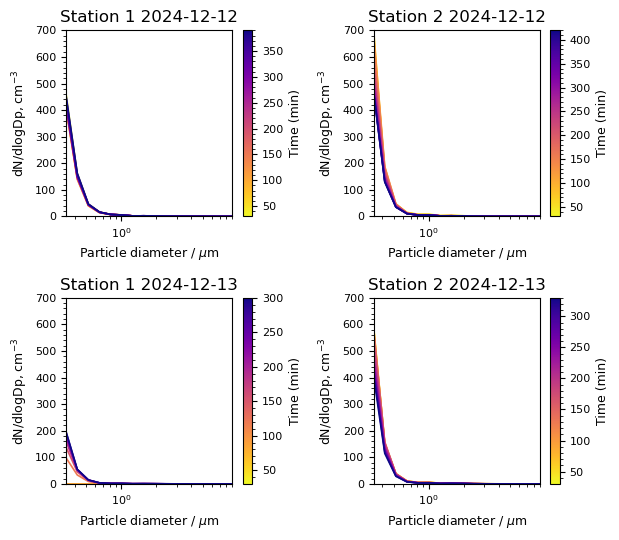

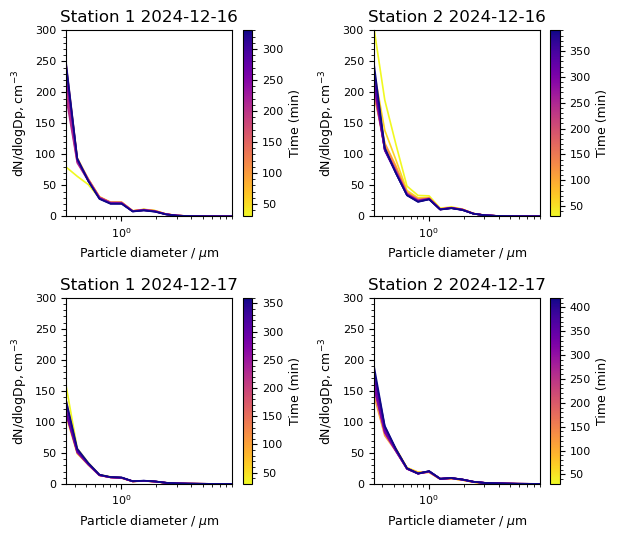

In [16]:
fig1, ax1 = plt.subplots(3, 2, figsize = (6.3, 8))
fig2, ax2 = plt.subplots(2, 2, figsize = (6.3, 5.5))
fig3, ax3 = plt.subplots(2, 2, figsize = (6.3, 5.5))

for i, key in enumerate(OPS1_dict_keys):
    date = timestamps[i][0].split(' ')[0]
    key_s2 = OPS2_dict_keys[i]

    if i < 3:
        plot_running_mean(fig1, ax1[i][0], OPS1_running[key + ' number'], OPS_mid_point, OPS_cut_point, ax_labels[:2], 30, False)
        plot_running_mean(fig1, ax1[i][1], OPS2_running[key_s2 + ' number'], OPS_mid_point, OPS_cut_point, ax_labels[:2], 30, False)

        ax1[i][0].set(title = 'Station 1 ' + date, ylim = (0, 750))
        ax1[i][1].set(title = 'Station 2 ' + date, ylim = (0, 750))

        fig1.tight_layout()
        fig1.savefig('Running_mean/OPS_running_number_CPH-hall.png', dpi = 600)

    if 2 < i < 5:
        plot_running_mean(fig2, ax2[i-3][0], OPS1_running[key + ' number'], OPS_mid_point, OPS_cut_point, ax_labels[:2], 30, False)
        plot_running_mean(fig2, ax2[i-3][1], OPS2_running[key_s2 + ' number'], OPS_mid_point, OPS_cut_point, ax_labels[:2], 30, False)

        ax2[i-3][0].set(title = 'Station 1 ' + date, ylim = (0, 700))
        ax2[i-3][1].set(title = 'Station 2 ' + date, ylim = (0, 700))

        fig2.tight_layout()
        fig2.savefig('Running_mean/OPS_running_number_CPH-platform.png', dpi = 600)

    if i > 4:
        plot_running_mean(fig3, ax3[i-5][0], OPS1_running[key + ' number'], OPS_mid_point, OPS_cut_point, ax_labels[:2], 30, False)
        plot_running_mean(fig3, ax3[i-5][1], OPS2_running[key_s2 + ' number'], OPS_mid_point, OPS_cut_point, ax_labels[:2], 30, False)

        ax3[i-5][0].set(title = 'Station 1 ' + date, ylim = (0, 300))
        ax3[i-5][1].set(title = 'Station 2 ' + date, ylim = (0, 300))

        fig3.tight_layout()
        fig3.savefig('Running_mean/OPS_running_number_NP.png', dpi = 600)

C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\1094382134.py:16: UserWarning: The figure layout has changed to tight
  fig1.tight_layout()
C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\1094382134.py:26: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()
C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\1094382134.py:36: UserWarning: The figure layout has changed to tight
  fig3.tight_layout()


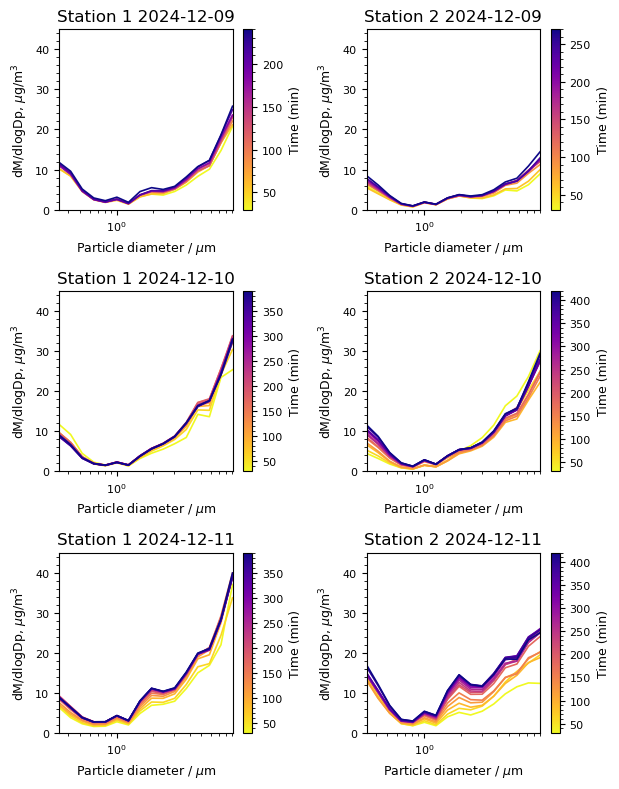

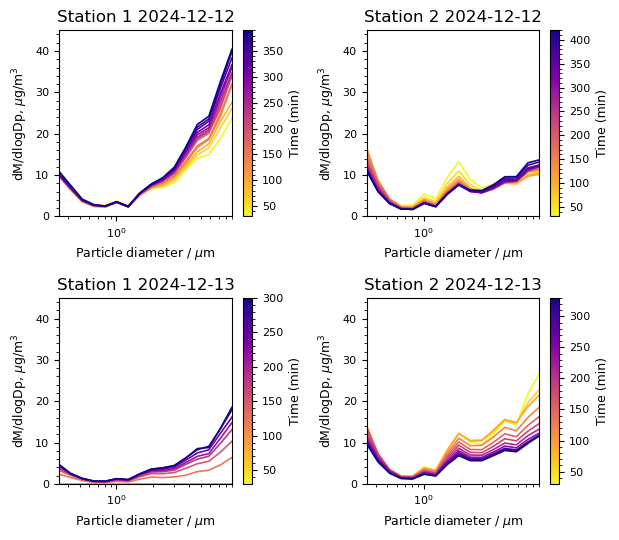

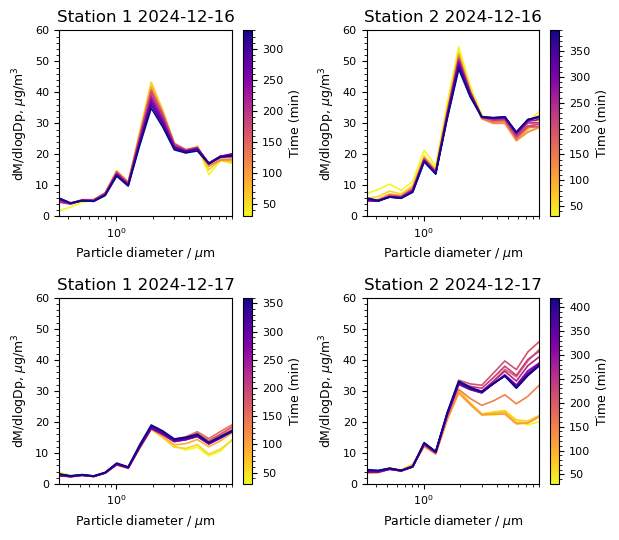

In [20]:
fig1, ax1 = plt.subplots(3, 2, figsize = (6.3, 8))
fig2, ax2 = plt.subplots(2, 2, figsize = (6.3, 5.5))
fig3, ax3 = plt.subplots(2, 2, figsize = (6.3, 5.5))

for i, key in enumerate(OPS1_dict_keys):
    date = timestamps[i][0].split(' ')[0]
    key_s2 = OPS2_dict_keys[i]

    if i < 3:
        plot_running_mean(fig1, ax1[i][0], OPS1_running[key + ' mass'], OPS_mid_point, OPS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)
        plot_running_mean(fig1, ax1[i][1], OPS2_running[key_s2 + ' mass'], OPS_mid_point, OPS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)

        ax1[i][0].set(title = 'Station 1 ' + date, ylim = (0, 45))
        ax1[i][1].set(title = 'Station 2 ' + date, ylim = (0, 45))

        fig1.tight_layout()
        fig1.savefig('Running_mean/OPS_running_mass_CPH-hall.png', dpi = 600)

    if 2 < i < 5:
        plot_running_mean(fig2, ax2[i-3][0], OPS1_running[key + ' mass'], OPS_mid_point, OPS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)
        plot_running_mean(fig2, ax2[i-3][1], OPS2_running[key_s2 + ' mass'], OPS_mid_point, OPS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)

        ax2[i-3][0].set(title = 'Station 1 ' + date, ylim = (0, 45))
        ax2[i-3][1].set(title = 'Station 2 ' + date, ylim = (0, 45))

        fig2.tight_layout()
        fig2.savefig('Running_mean/OPS_running_mass_CPH-platform.png', dpi = 600)

    if i > 4:
        plot_running_mean(fig3, ax3[i-5][0], OPS1_running[key + ' mass'], OPS_mid_point, OPS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)
        plot_running_mean(fig3, ax3[i-5][1], OPS2_running[key_s2 + ' mass'], OPS_mid_point, OPS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)

        ax3[i-5][0].set(title = 'Station 1 ' + date, ylim = (0, 60))
        ax3[i-5][1].set(title = 'Station 2 ' + date, ylim = (0, 60))

        fig3.tight_layout()
        fig3.savefig('Running_mean/OPS_running_mass_NP.png', dpi = 600)

C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\1200555055.py:15: UserWarning: The figure layout has changed to tight
  fig1.tight_layout()
C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\1200555055.py:24: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()
C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\1200555055.py:34: UserWarning: The figure layout has changed to tight
  fig3.tight_layout()


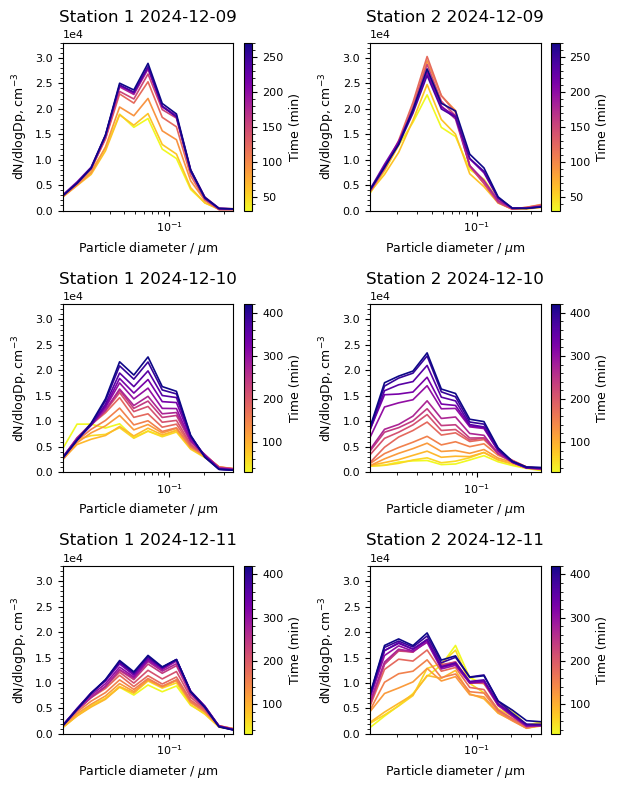

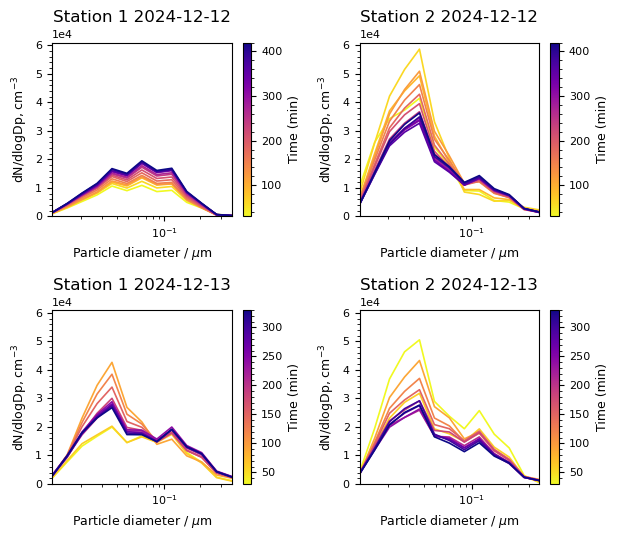

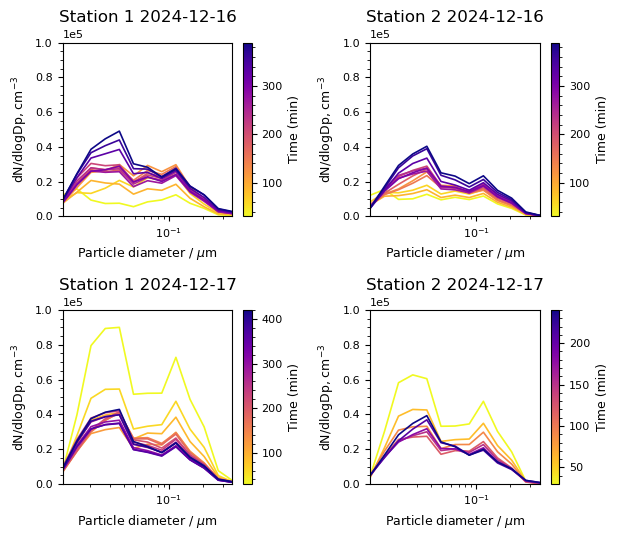

In [25]:
fig1, ax1 = plt.subplots(3, 2, figsize = (6.3, 8))
fig2, ax2 = plt.subplots(2, 2, figsize = (6.3, 5.5))
fig3, ax3 = plt.subplots(2, 2, figsize = (6.3, 5.5))

for i, key in enumerate(NS_dict_keys):
    date = timestamps[i][0].split(' ')[0]

    if i < 3:
        plot_running_mean(fig1, ax1[i][0], NS1_running[key + ' number'], NS_bin_mean, NS_cut_point, ax_labels[:2], 30, False)
        plot_running_mean(fig1, ax1[i][1], NS2_running[key + ' number'], NS_bin_mean, NS_cut_point, ax_labels[:2], 30, False)

        ax1[i][0].set(title = 'Station 1 ' + date, ylim = (0, 3.3*10**4))
        ax1[i][1].set(title = 'Station 2 ' + date, ylim = (0, 3.3*10**4))

        fig1.tight_layout()
        fig1.savefig('Running_mean/NS_running_number_CPH-hall.png', dpi = 600)

    if 2 < i < 5:
        plot_running_mean(fig2, ax2[i-3][0], NS1_running[key + ' number'], NS_bin_mean, NS_cut_point, ax_labels[:2], 30, False)
        plot_running_mean(fig2, ax2[i-3][1], NS2_running[key + ' number'], NS_bin_mean, NS_cut_point, ax_labels[:2], 30, False)
        ax2[i-3][0].set(title = 'Station 1 ' + date, ylim = (0, 6.1*10**4))
        ax2[i-3][1].set(title = 'Station 2 ' + date, ylim = (0, 6.1*10**4))

        fig2.tight_layout()
        fig2.savefig('Running_mean/NS_running_number_CPH-platform.png', dpi = 600)

    if i > 4:
        plot_running_mean(fig3, ax3[i-5][0], NS1_running[key + ' number'], NS_bin_mean, NS_cut_point, ax_labels[:2], 30, False)
        plot_running_mean(fig3, ax3[i-5][1], NS2_running[key + ' number'], NS_bin_mean, NS_cut_point, ax_labels[:2], 30, False)

        ax3[i-5][0].set(title = 'Station 1 ' + date, ylim = (0, 10**5))
        ax3[i-5][1].set(title = 'Station 2 ' + date, ylim = (0, 10**5))

        fig3.tight_layout()
        fig3.savefig('Running_mean/NS_running_number_NP.png', dpi = 600)

C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\636494439.py:15: UserWarning: The figure layout has changed to tight
  fig1.tight_layout()
C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\636494439.py:24: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()
C:\Users\B363580\AppData\Local\Temp\ipykernel_4904\636494439.py:34: UserWarning: The figure layout has changed to tight
  fig3.tight_layout()


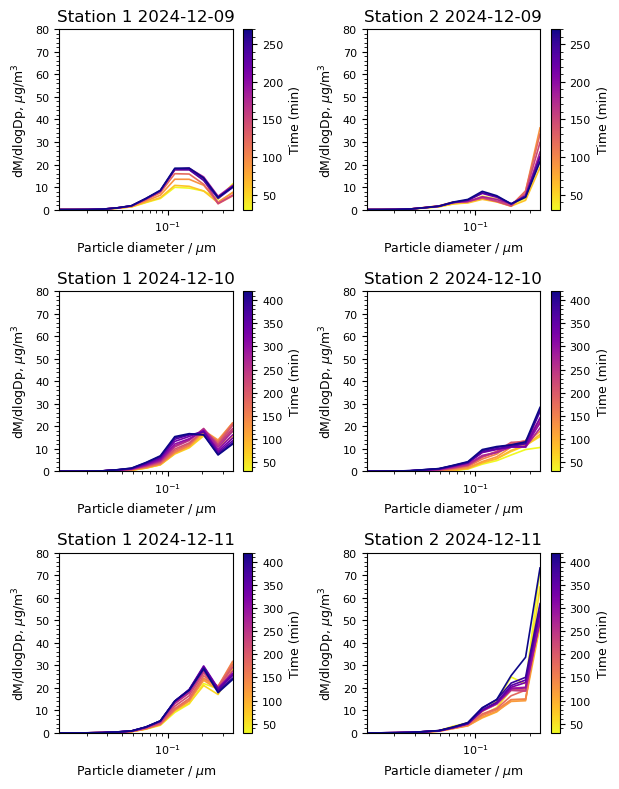

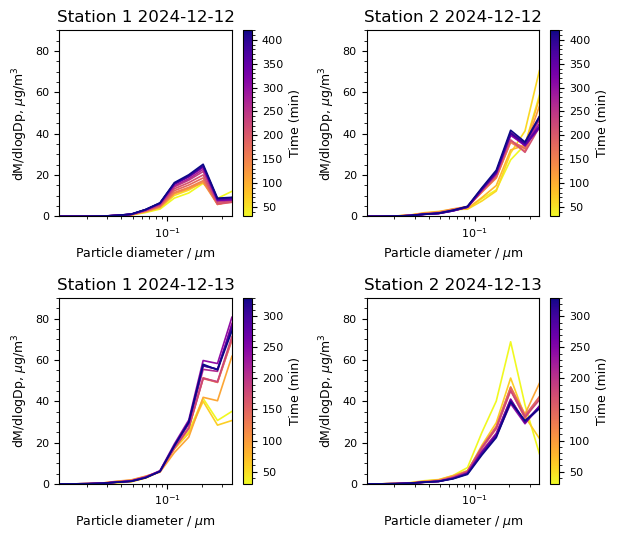

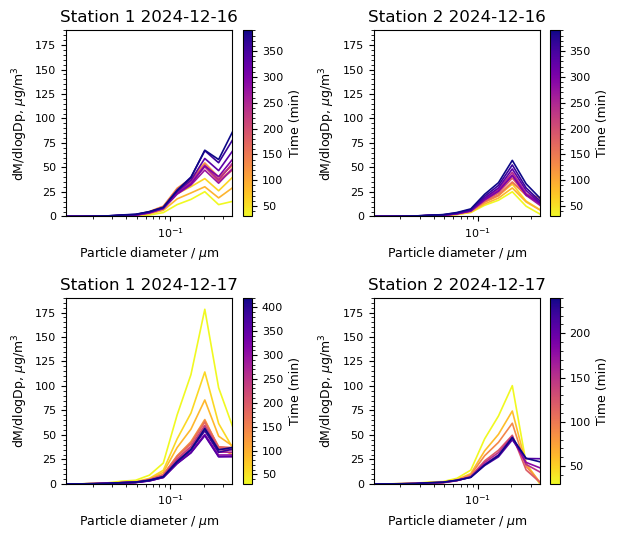

In [29]:
fig1, ax1 = plt.subplots(3, 2, figsize = (6.3, 8))
fig2, ax2 = plt.subplots(2, 2, figsize = (6.3, 5.5))
fig3, ax3 = plt.subplots(2, 2, figsize = (6.3, 5.5))

for i, key in enumerate(NS_dict_keys):
    date = timestamps[i][0].split(' ')[0]

    if i < 3:
        plot_running_mean(fig1, ax1[i][0], NS1_running[key + ' mass'], NS_bin_mean, NS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)
        plot_running_mean(fig1, ax1[i][1], NS2_running[key + ' mass'], NS_bin_mean, NS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)

        ax1[i][0].set(title = 'Station 1 ' + date, ylim = (0, 80))
        ax1[i][1].set(title = 'Station 2 ' + date, ylim = (0, 80))

        fig1.tight_layout()
        fig1.savefig('Running_mean/NS_running_mass_CPH-hall.png', dpi = 600)

    if 2 < i < 5:
        plot_running_mean(fig2, ax2[i-3][0], NS1_running[key + ' mass'], NS_bin_mean, NS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)
        plot_running_mean(fig2, ax2[i-3][1], NS2_running[key + ' mass'], NS_bin_mean, NS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)
        ax2[i-3][0].set(title = 'Station 1 ' + date, ylim = (0, 90))
        ax2[i-3][1].set(title = 'Station 2 ' + date, ylim = (0, 90))

        fig2.tight_layout()
        fig2.savefig('Running_mean/NS_running_mass_CPH-platform.png', dpi = 600)

    if i > 4:
        plot_running_mean(fig3, ax3[i-5][0], NS1_running[key + ' mass'], NS_bin_mean, NS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)
        plot_running_mean(fig3, ax3[i-5][1], NS2_running[key + ' mass'], NS_bin_mean, NS_cut_point, [ax_labels[0], ax_labels[2]], 30, False)

        ax3[i-5][0].set(title = 'Station 1 ' + date, ylim = (0, 190))
        ax3[i-5][1].set(title = 'Station 2 ' + date, ylim = (0, 190))

        fig3.tight_layout()
        fig3.savefig('Running_mean/NS_running_mass_NP.png', dpi = 600)